# Emotion Detection in Written Sentences
## Exploratory Data Analysis (EDA)

Testing if the data set has null values and how balanced it is


Missing Values:
 Unnamed: 0    0
text          0
label         0
dtype: int64
Number of Duplicates: 22987
Dataset Shape: (416809, 3)


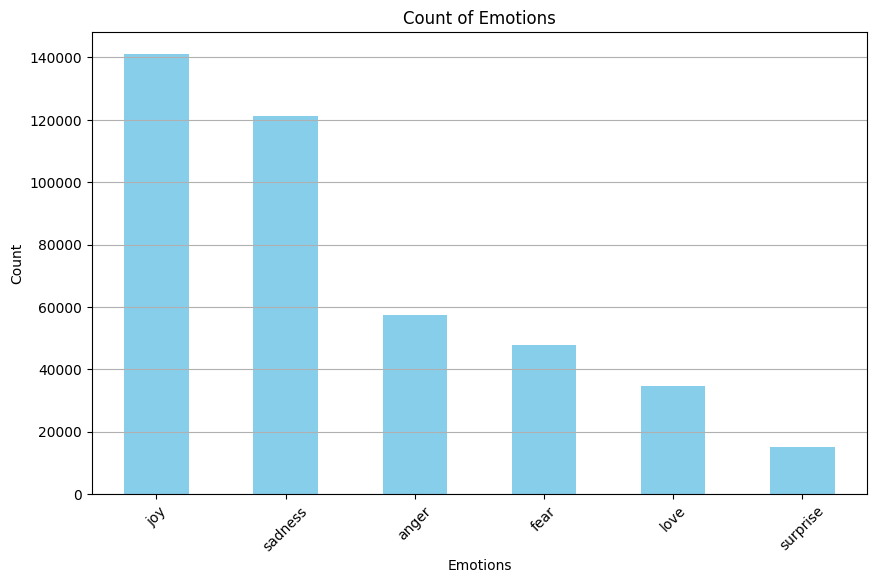

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

df = pd.read_csv('text.csv')
print("\nMissing Values:\n", df.isnull().sum())
duplicates_count = df.duplicated(subset='text').sum()

print("Number of Duplicates:", duplicates_count)
print("Dataset Shape:", df.shape)

def plot_emotions(df):
    emotion_map = {
        0: 'sadness',
        1: 'joy',
        2: 'love',
        3: 'anger',
        4: 'fear',
        5: 'surprise'
    }
    plt.figure(figsize=(10, 6))
    df['label'].replace(emotion_map).value_counts().plot(kind='bar', color='skyblue')
    plt.title('Count of Emotions')
    plt.xlabel('Emotions')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

plot_emotions(df)


Conclusion:

- There are no null values.
- There are 22987 duplicates in the dataset, which requires handling missing values.
- The dataset is not well-balanced among the different emotional categories, which requires applying undersampling techniques.

## Undersampling and droping duplicates

Number of Duplicates after: 0
Dataset Shape after: (393822, 3)


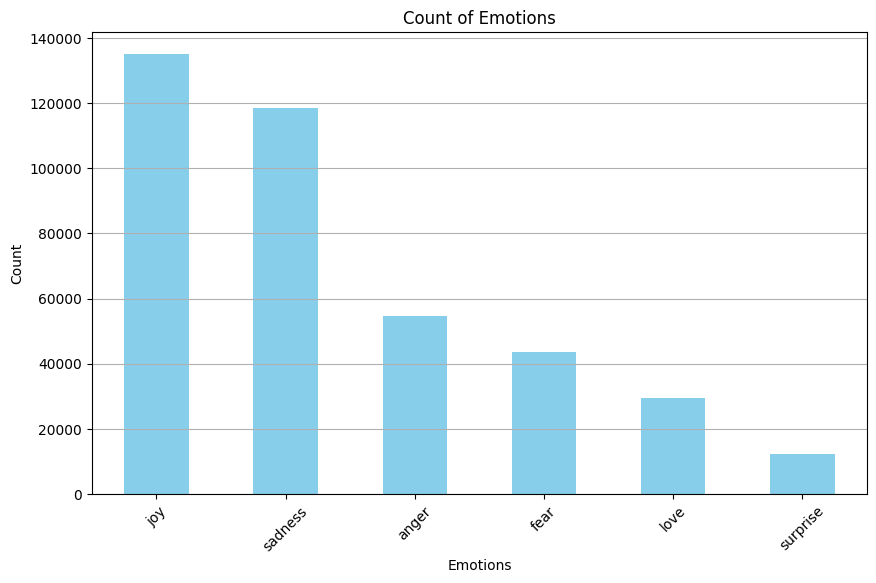

After undersampling
Final Dataset Shape: (74442, 3)


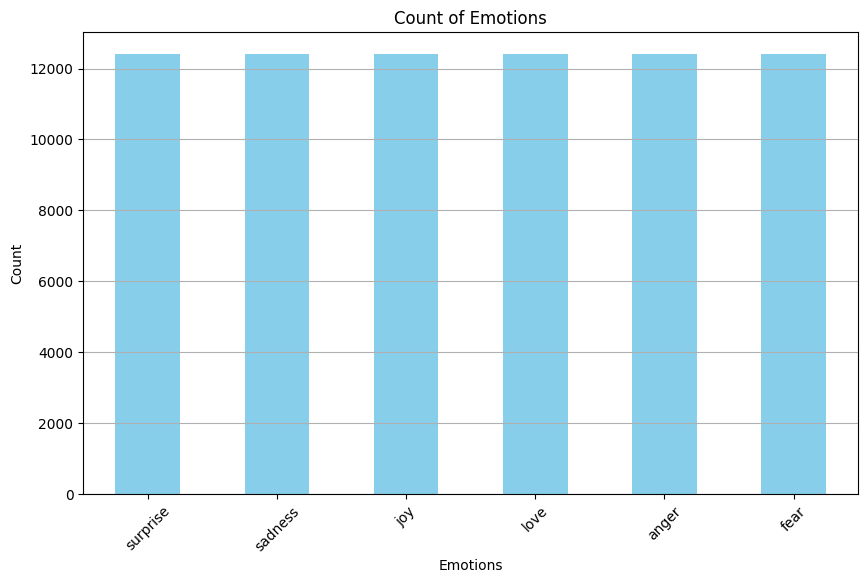

In [8]:
df_after = df.drop_duplicates(subset=['text'], keep='first')
duplicates_count = df_after.duplicated(subset='text').sum()
print("Number of Duplicates after:", duplicates_count)
print("Dataset Shape after:", df_after.shape)
plot_emotions(df_after)


df_minority = df_after[df_after['label'] == 5]
df_final = df_minority

def undersample(emotion):
    global df_final
    df_majority = df_after[df_after['label'] == emotion]

    df_majority_undersampled = resample(df_majority,replace=False,n_samples=len(df_minority),random_state=42)
    df_final = pd.concat([df_final,df_majority_undersampled])

for i in [0,1,2,3,4]:
    undersample(i)
    
print("After undersampling")
print("Final Dataset Shape:", df_final.shape)
plot_emotions(df_final)

-The dataset is now well-balanced among the different emotional categories, which allows us to proceed

## Data preparation

Spliting the dataset into train and test part in 80-20 ratio

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

sentences = df_final['text'].values
emotions = df_final['label'].values

X_train, X_test, y_train, y_test = train_test_split(sentences, emotions, test_size=0.2, random_state=42)

X_train = pd.Series(X_train)
y_train = pd.Series(y_train)
X_test = pd.Series(X_test)
y_test = pd.Series(y_test)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.columns = [ 'text', 'emotion']
test_df.columns = [ 'text', 'emotion']
train_df.head()

,text,emotion
0,i saw her i feel like i was travelling back to...,0
1,i leaves bambi feeling amazed yet irritated co...,5
2,i feel pressured to move forward with these jobs,4
3,i am feelin stunned out ohhhh now i am feelin ...,5
4,i hate that it sometimes takes a disaster to b...,1


## Preprocessing and text normalization

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import ssl
from joblib import Parallel, delayed
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

tt = preprocess_text("The cats are playing, in the garden and running around?")

def preprocess_text_parallel(train_df):
    return Parallel(n_jobs=-1, prefer="threads")(delayed(preprocess_text)(text) for text in train_df)


train_df["text"] = preprocess_text_parallel(train_df["text"])
test_df["text"] = preprocess_text_parallel(test_df["text"])
train_df.head()

,text,emotion
0,saw feel like travel back time little girl eve...,0
1,leave bambi feel amaze yet irritate consider n...,5
2,feel pressure move forward job,4
3,feelin stun ohhhh feelin stun huu uh feelin st...,5
4,hate sometimes take disaster bring community s...,1


## TF-IDF

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 3))
#razlicite parametre probati

X_train_tfidf = tfidf_vectorizer.fit_transform(train_df["text"])
X_test_tfidf = tfidf_vectorizer.transform(test_df["text"])


tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df.head()

,aa,aa finally,aa finally feel,aa meet,aa meet would,aa methodology,aa methodology weight,aaaa,aaaa whatever,aaaa whatever want,...,zygi less impress,zygote,zylstra,zylstra topic,zylstra topic feel,zzz,zzzz,zzzz know,zzzz know ive,zzzzzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Evaluation methods

In [12]:

def evaluation(x_pred, y_pred, y_val):
    accuracy = accuracy_score(y_val, y_pred)
    print("Accuracy:", accuracy)
    
    macro_average = f1_score(y_val, y_pred, average='macro')
    print("Macro-average F1 score:", macro_average)
    
    print("Classification Report:")
    print(classification_report(y_val, y_pred))
    
    display_labels = ['sadness', 'joy', 'love', 'anger', 'fear', "surprise"]
    cm = confusion_matrix(y_val,y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=display_labels) 
    cm_display.plot()
    plt.xticks(np.arange(len(display_labels)), display_labels, rotation=45, ha='right')
    plt.show()

## SVM model
Finding the best parameters for the dataset

Accuracy: 0.9176965789002328
Macro-average F1 score: 0.9176359569376733
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1867
           1       0.93      0.88      0.90      1919
           2       0.88      0.96      0.92      1833
           3       0.94      0.91      0.92      1867
           4       0.94      0.88      0.91      1892
           5       0.89      0.99      0.94      1788

    accuracy                           0.92     11166
   macro avg       0.92      0.92      0.92     11166
weighted avg       0.92      0.92      0.92     11166



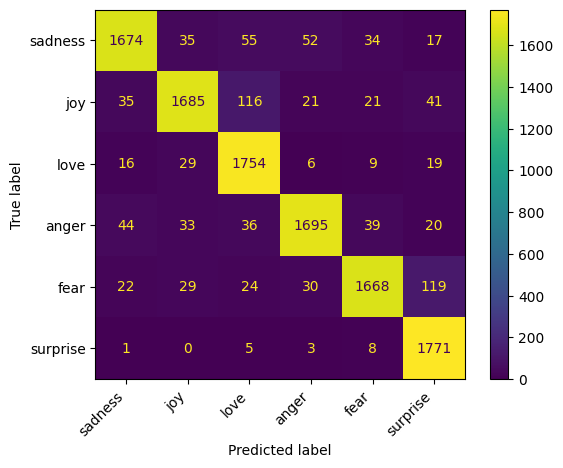

Best Parameters: {'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
Best Score: 0.91045


In [19]:
# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],                # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1],         # Kernel coefficient for 'rbf', 'poly', 'sigmoid'
    'kernel': ['linear', 'rbf', 'poly']    # Kernel type
}

# Initialize SVM classifier
svm_model = SVC()

# Setup GridSearchCV
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_tfidf[:20000], y_train[:20000])

# Print best parameters and best score
y_pred = grid_search.predict(X_val_tfidf)
evaluation(X_val_tfidf, y_pred, y_val)


print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Testing parameters

Accuracy: 0.9284434891635321
Macro-average F1 score: 0.9283997611746407
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1867
           1       0.95      0.88      0.92      1919
           2       0.90      0.96      0.93      1833
           3       0.95      0.92      0.93      1867
           4       0.94      0.90      0.92      1892
           5       0.89      1.00      0.94      1788

    accuracy                           0.93     11166
   macro avg       0.93      0.93      0.93     11166
weighted avg       0.93      0.93      0.93     11166



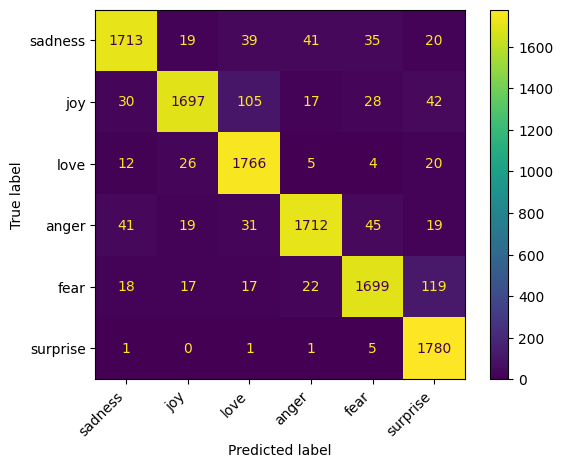

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', C=1, gamma=0.001, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
svm_pred = svm_model.predict(X_val_tfidf)

evaluation(X_val_tfidf, svm_pred, y_val)


## GBT model
Finding the best parameters

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf[:1000], y_train[:1000])
best_gbt_model = grid_search.best_estimator_
val_predictions = best_gbt_model.predict(X_test_tfidf[:1000])

evaluation(X_test_tfidf[:1000], val_predictions, y_test[:1000])

Accuracy: 0.8797
Macro-average F1 score: 0.8802572024435874
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      1655
           1       0.75      0.87      0.80      1709
           2       0.89      0.92      0.90      1680
           3       0.91      0.86      0.88      1670
           4       0.92      0.84      0.88      1613
           5       0.90      0.99      0.94      1673

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



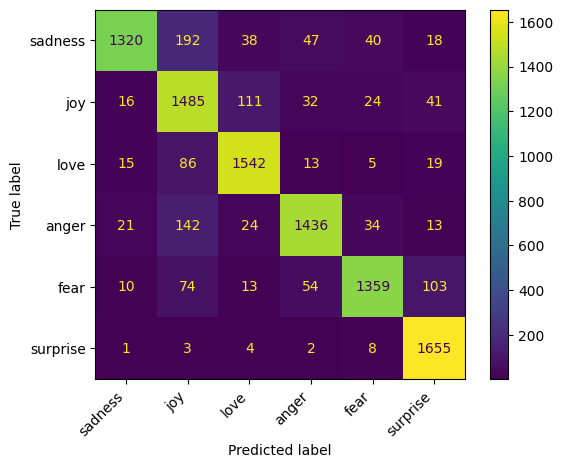

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

gbt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

gbt_model.fit(X_train_tfidf[:10000], y_train[:10000])
print("1")
gbt_pred = gbt_model.predict(X_test_tfidf[:10000])

evaluation(X_test_tfidf[:10000], gbt_pred, y_test[:10000])


## CNN model

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

print("1")
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# random.shuffle(X_train_tfidf)
# random.shuffle(y_train)
# random.shuffle(X_test_tfidf)
# random.shuffle(y_test)

# vocab_size = 5000
# embedding_dim = 50
# input_length = 10

# model = Sequential()
# model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=input_length))
# model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(units=10, activation='relu'))
# model.add(Dense(units=5, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()
# print("1")
# history = model.fit(X_train_tfidf[:1000], y_train[:1000], epochs=10, validation_data=(X_test_tfidf[:1000], y_test[:1000]), batch_size=32)
# print("2")

# loss, accuracy = model.evaluate(X_test_tfidf[:1000], y_test[:1000])
# print(f'Test Accuracy: {accuracy}')

1
